In [1]:
%run ./CoreFunctions.ipynb

In [2]:
playsound(444,444)

In [3]:

    
aLowestValue = -0.54
aHighestValue = aLowestValue + 3
bLowestValue = -1.54
bHighestValue = bLowestValue + 3

In [4]:
# Q values come below, after initialize cities array is defined

In [37]:
distance_to_points = 0.225  # determins how many new points are included per iteration
                            # higher value results in fewer iterations but more points will be computed
                            # if the value is too low, some points may be missed. Not good
                            # if the value is too high, too many points will be computed
                            # also, a low value may cause problems with the gaussian regression 
        
        
Grid_size = 57             # the grid of Grid_size ^2 points is considered

In [6]:
#Polush population
#Pol_Pop = pd.read_csv("beta_30_Pl_AA.csv")
#PolPopulation = np.array(Pol_Pop["SourcePopulation"])
#PolPopulation = np.sort(PolPopulation)

In [7]:
N_iterations = 39 
#N_cities = len(PolPopulation)
N_cities = 4 #number of city sizes

In [8]:
# kI  does not! affect the ratio I_p/I_u!
kI = 0.00001

In [9]:
# initialize cities array. The distribution is given manually
if True:
    def initialize_cities_array():
        
        # zeroth column is city size y, first is beta(y), second is pi_p(y), third  pi_U(y)
        zeta      = np.zeros((N_cities, 4))
        zeta[0,0] = 1000
        zeta[1,0] = 25369
        zeta[2,0] = 110521
        zeta[3,0] = 787445
        
        zeta[0,1] = 0.09
        zeta[1,1] = 0.05
        zeta[2,1] = 0.85
        zeta[3,1] = 0.01
        
        zeta[:,2] = 0.99 #placeholder
        zeta[:,3] = 0.99  #placeholder
    
    
        return zeta

In [10]:
# for Poland all city sizes are unique
if False:   
    def initialize_cities_array():
        
        # zeroth column is city size y, first is beta(y), second is pi_p(y), third  pi_U(y)
        zeta      = np.zeros((N_cities, 4))
        zeta[:,0] = PolPopulation
     
        
        zeta[:,1] = 1/N_cities
        
        zeta[:,2] = 0.99 #placeholder
        zeta[:,3] = 0.99  #placeholder
    
    
        return zeta

In [11]:
Q_values = np.array([0.01, 0.07, 0.5, 0.93, 0.99]) * maxQ_value()
#Q_values = np.array([0.3]) * maxQ_value()

In [12]:
Q_values

array([  1031.7575,   7222.3025,  51587.875 ,  95953.4475, 102143.9925])

In [13]:
if np.max(Q_values) > maxQ_value() - 0.1:
    raise ValueError("Q_value is too high!")

In [14]:
def getPointsCloseToBoundary(df, DF_boundary, distance_to_points ):
    Points_close_to_the_boundary = []

    for i in range(df.shape[0]):   # add points close to the old boundary
        ai = df["a"][i]
        bi = df["b"][i]
        Distance = 1
        for j in range(DF_boundary.shape[0]):
            aj = DF_boundary["a"][j]
            bj = DF_boundary["b"][j]
            Distance = ( (ai - aj) **2 + (bi - bj) **2  )**(0.5)
            if Distance < distance_to_points:
                Points_close_to_the_boundary.append(i)
                break

    Returndf = df.iloc[Points_close_to_the_boundary] 
    Returndf = Returndf.reset_index(drop=True) # reset indices
    
    return Returndf

def getBoundary(df, Delta):
    #print(Delta)
    Indices_of_boundary_points = []

    for i in range(df.shape[0]):
        ai = df["a"][i]
        bi = df["b"][i]

        for j in range(i+1): 
            aj = df["a"][j]
            bj = df["b"][j]
            GraphDistance = (abs(ai-aj) + abs(bi-bj))/ Delta
            if GraphDistance > 0.5 and GraphDistance < 1.5:
                #print("pair")
                if abs(df["Signs"][i]- df["Signs"][j]) > 0.5:
                    Indices_of_boundary_points.extend([i,j])

                    
    Indices_of_boundary_points =  list(set(Indices_of_boundary_points))
    DF_boundary = df.iloc[Indices_of_boundary_points]
    DF_boundary = DF_boundary.reset_index(drop=True)
                    
    return DF_boundary


In [15]:
def Compute_df_near_boundary(Q_value, PlotFigures = True): # depends also on beta ofc

    iteration_number = 0

    Boundary_is_invariant = False

    while iteration_number < 81 and not Boundary_is_invariant:

        iteration_number = iteration_number +1
        print( "Iteration number " + str(iteration_number) + " has began...")
        aas = np.linspace(start=aLowestValue, stop= aHighestValue, num=Grid_size) 
        bbs = np.linspace(start=bLowestValue, stop= bHighestValue, num=Grid_size)
        if iteration_number == 1: 
            aas = np.linspace(start=0.3, stop=1.7, num=11) 
            bbs = np.linspace(start=0.3 - 1, stop=1.7 - 1, num=11)
        Delta = (np.max(aas) - np.min(aas))/(np.shape(aas)[0])

        # get cartesian product of aas and bbs
        df = pd.MultiIndex.from_product([aas, bbs], names = ["a", "b"])
        df = pd.DataFrame(index = df).reset_index()
        zeros = np.zeros(( df.shape[0],1))
        df["LogIpOverIu"] = zeros  
        df = df.sample(frac=1).reset_index(drop=True)  #shuffle rows

        if iteration_number == 2:
            df = getPointsCloseToBoundary(df, DF_boundary, 1.2*distance_to_points)
        if iteration_number > 2.2:
            df = getPointsCloseToBoundary(df, DF_boundary, distance_to_points)



        if PlotFigures == True:

            plt.scatter(df["a"], df["b"], s=1)
            plt.xlabel("a")
            plt.ylabel("b")
            plt.title('df points')
            plt.show()



        startTime = time.time()
        for i in range(df.shape[0]):

            ai = df["a"][i]
            bi = df["b"][i]

            Index_in_Computed_points = -2  # remains negative if this has not been computed
            if iteration_number > 2.2:

                for j in range(Computed_points.shape[0]):
                    aj = Computed_points["a"][j]
                    bj = Computed_points["b"][j]

                    if abs(ai - aj) + abs( bi - bj) < 0.0001:
                        Index_in_Computed_points = j
                        break

            if Index_in_Computed_points > -0.5:
                df["LogIpOverIu"][i] = Computed_points["LogIpOverIu"][Index_in_Computed_points]
            elif abs(Index_in_Computed_points +2) < 0.001:
                ick = Compute_Is(df["a"][i], df["b"][i], Q_value)
                df["LogIpOverIu"][i] = math.log(ick[0]) - math.log(ick[1])
            else:
                raise ValueError('Sth bad happened with Index_in_Computed_points')

            if  i%73 == 5:
                print("ETA for LogIpOverIu computation in this iteration = " +
                      str( (df.shape[0] - i - 1) *(time.time() - startTime)/(i+1) ) + " seconds")

        print("Total time for LogIpOverIu computation in this iteration = "  + str(time.time() - startTime) )      
        if iteration_number == 2:
            Computed_points = df.copy()

        if iteration_number > 2:
            Computed_points = pd.concat([Computed_points,df]).drop_duplicates().reset_index(drop=True)

        df["Signs"] = 0
        for i in range(len(df)):
            if df["LogIpOverIu"][i] > 0:
                 df.loc[i, "Signs"]  = 1
            elif df["LogIpOverIu"][i] < 0:
                 df.loc[i, "Signs"]  = -1
        
        if PlotFigures == True:
            plt.scatter(df["a"], df["b"], c=df["Signs"], s=1)
            plt.ylabel('b')
            plt.xlabel('a')
            plt.title("df dataframe")

        plt.show()
        if iteration_number > 1.2:
            DF_boundary_old = DF_boundary.copy()

        DF_boundary = getBoundary(df, Delta)
        Signs_boundary = np.zeros(np.shape(DF_boundary["LogIpOverIu"]))
        for i in range(len(Signs_boundary)):
            if DF_boundary["LogIpOverIu"][i] > 0:
                Signs_boundary[i] = 1
            elif DF_boundary["LogIpOverIu"][i] < 0:
                Signs_boundary[i] = -1

        if iteration_number > 3.2:
            if DF_boundary.shape[0] == DF_boundary_old.shape[0]:
                Boundary_is_invariant = True

        if PlotFigures == True:
            plt.scatter(DF_boundary["a"][Signs_boundary > 0], DF_boundary["b"][Signs_boundary > 0], c = "red", s=1)
            plt.scatter(DF_boundary["a"][Signs_boundary < 0], DF_boundary["b"][Signs_boundary < 0], c = "blue", s=1)
            plt.ylabel('b')
            plt.xlabel('a')
            plt.title("DF_boundary")
            plt.show()
    plt.scatter(DF_boundary["a"][Signs_boundary > 0], DF_boundary["b"][Signs_boundary > 0], c = "red", s=1)
    plt.scatter(DF_boundary["a"][Signs_boundary < 0], DF_boundary["b"][Signs_boundary < 0], c = "blue", s=1)
    plt.ylabel('b')
    plt.xlabel('a')
    plt.title("DF_boundary")
    plt.show()
    
    return df

In [16]:
    from sklearn.gaussian_process import GaussianProcessRegressor
    from sklearn.gaussian_process.kernels import RBF
    


Iteration number 1 has began...


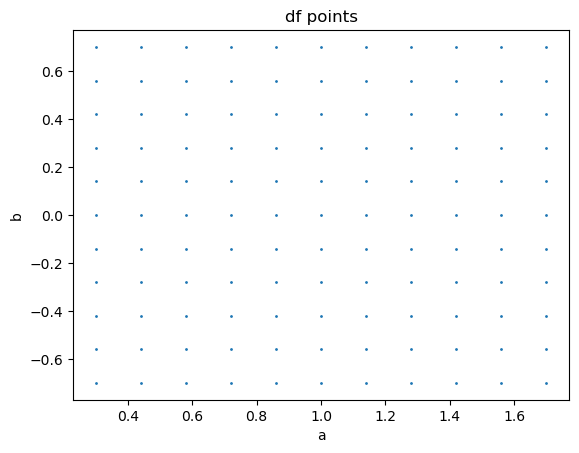

ETA for LogIpOverIu computation in this iteration = 20.29673715432485 seconds
ETA for LogIpOverIu computation in this iteration = 6.354579539238652 seconds
Total time for LogIpOverIu computation in this iteration = 18.300477743148804


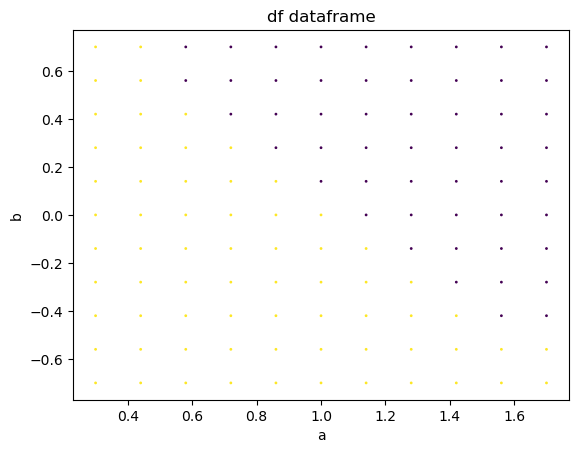

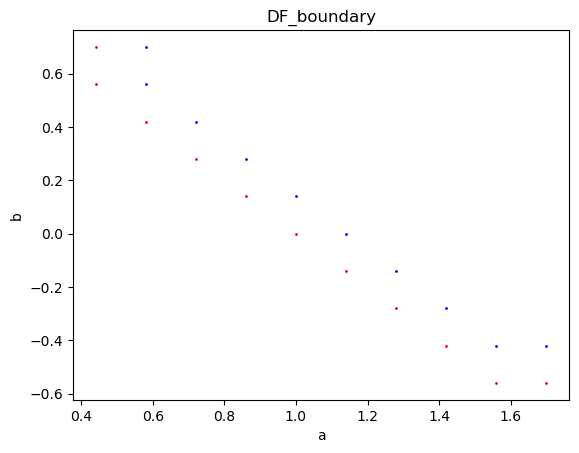

Iteration number 2 has began...


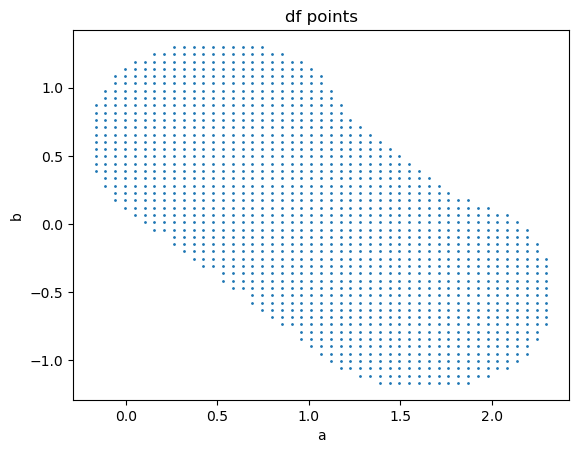

ETA for LogIpOverIu computation in this iteration = 194.89753246307373 seconds
ETA for LogIpOverIu computation in this iteration = 185.6076756278171 seconds
ETA for LogIpOverIu computation in this iteration = 170.3544920745649 seconds
ETA for LogIpOverIu computation in this iteration = 154.37489255905152 seconds
ETA for LogIpOverIu computation in this iteration = 143.7048609304748 seconds
ETA for LogIpOverIu computation in this iteration = 136.13296652225793 seconds
ETA for LogIpOverIu computation in this iteration = 127.5604945517875 seconds
ETA for LogIpOverIu computation in this iteration = 119.15220495487782 seconds
ETA for LogIpOverIu computation in this iteration = 107.32212281146292 seconds
ETA for LogIpOverIu computation in this iteration = 96.53698014457841 seconds
ETA for LogIpOverIu computation in this iteration = 86.36081077158451 seconds
ETA for LogIpOverIu computation in this iteration = 76.0511269265848 seconds
ETA for LogIpOverIu computation in this iteration = 65.39639

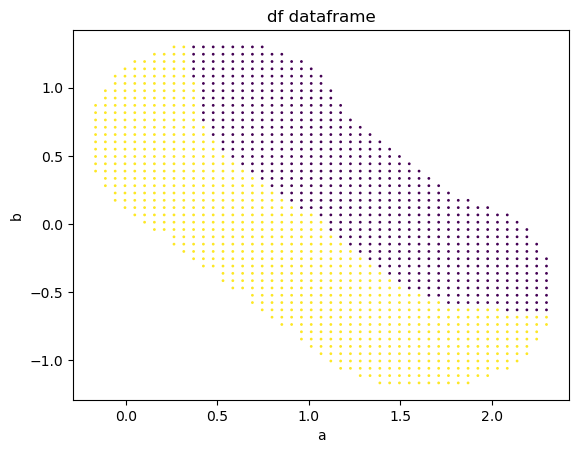

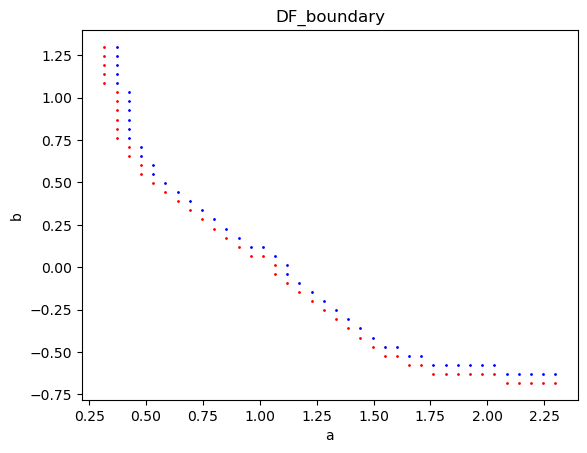

Iteration number 3 has began...


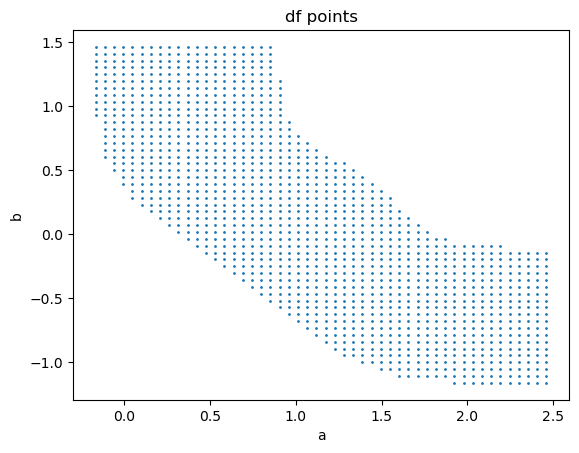

ETA for LogIpOverIu computation in this iteration = 62.5439453125 seconds
ETA for LogIpOverIu computation in this iteration = 59.16011406801924 seconds
ETA for LogIpOverIu computation in this iteration = 48.77015378914381 seconds
ETA for LogIpOverIu computation in this iteration = 44.97431834962633 seconds
ETA for LogIpOverIu computation in this iteration = 40.694883087337416 seconds
ETA for LogIpOverIu computation in this iteration = 37.93251300436467 seconds
ETA for LogIpOverIu computation in this iteration = 33.61622708445197 seconds
ETA for LogIpOverIu computation in this iteration = 29.17689017493213 seconds
ETA for LogIpOverIu computation in this iteration = 25.806743295313947 seconds
ETA for LogIpOverIu computation in this iteration = 23.485421554715025 seconds
ETA for LogIpOverIu computation in this iteration = 20.51621690068556 seconds
ETA for LogIpOverIu computation in this iteration = 17.790535504207917 seconds
ETA for LogIpOverIu computation in this iteration = 15.392712718

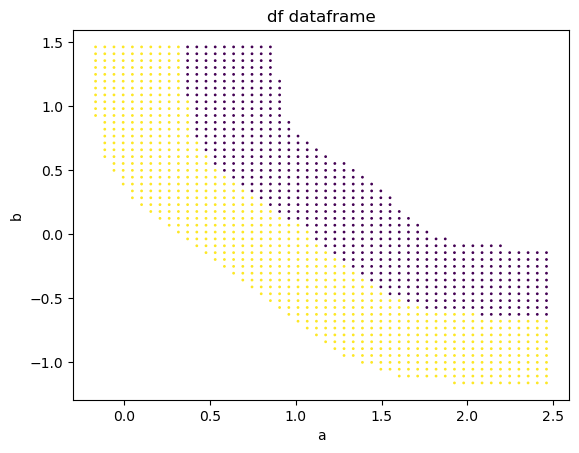

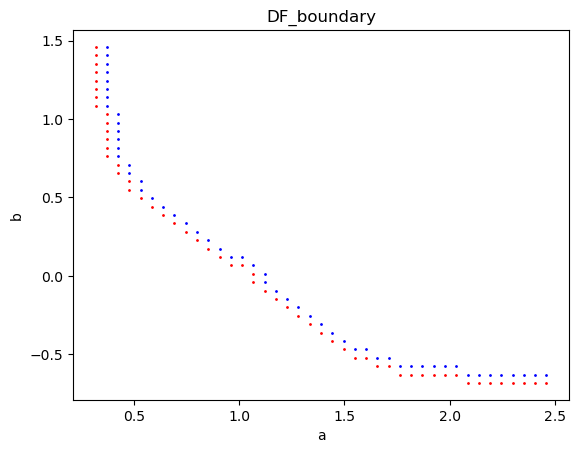

Iteration number 4 has began...


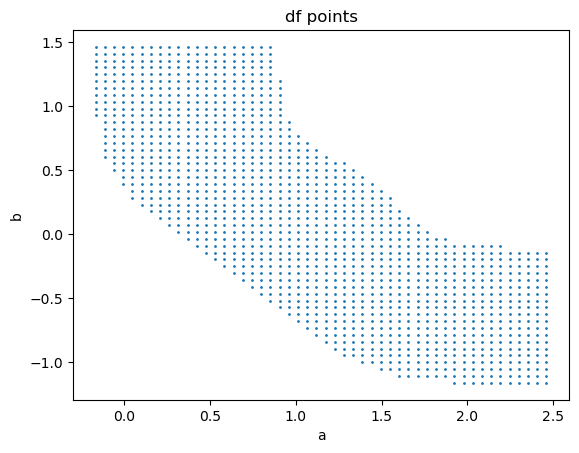

ETA for LogIpOverIu computation in this iteration = 21.699320475260418 seconds
ETA for LogIpOverIu computation in this iteration = 15.543332534500315 seconds
ETA for LogIpOverIu computation in this iteration = 14.659814395402607 seconds
ETA for LogIpOverIu computation in this iteration = 13.101987107594807 seconds
ETA for LogIpOverIu computation in this iteration = 12.19967206852548 seconds
ETA for LogIpOverIu computation in this iteration = 11.059004074801011 seconds
ETA for LogIpOverIu computation in this iteration = 10.102544703999081 seconds
ETA for LogIpOverIu computation in this iteration = 9.326369486648295 seconds
ETA for LogIpOverIu computation in this iteration = 8.41824542223397 seconds
ETA for LogIpOverIu computation in this iteration = 7.511459569226203 seconds
ETA for LogIpOverIu computation in this iteration = 6.635194757710332 seconds
ETA for LogIpOverIu computation in this iteration = 5.7460558576548495 seconds
ETA for LogIpOverIu computation in this iteration = 4.8453

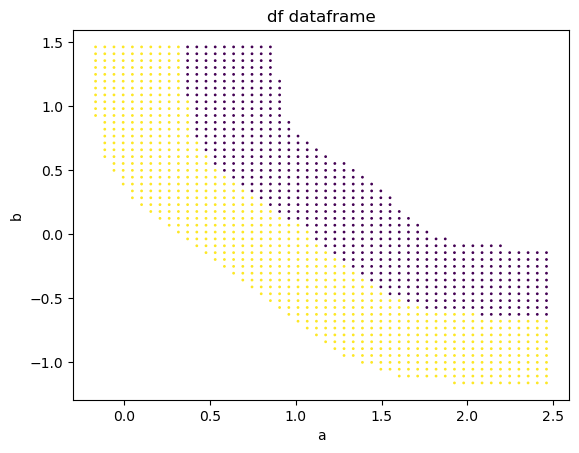

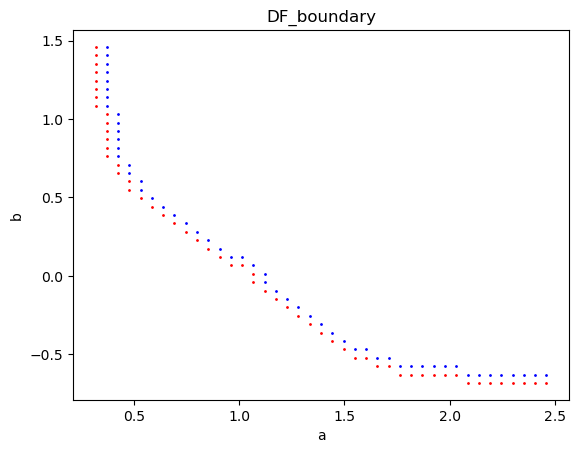

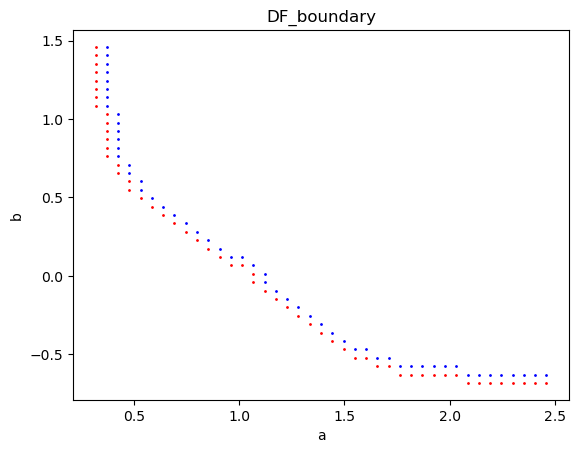

d:\Users\sinus\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


0.417**2 * RBF(length_scale=0.0915)
Sum of errors for the fit  = 0.004248561385381128
The value above should hopefully be small


Iteration number 1 has began...
ETA for LogIpOverIu computation in this iteration = 15.07820208867391 seconds
ETA for LogIpOverIu computation in this iteration = 6.172239466558529 seconds
Total time for LogIpOverIu computation in this iteration = 17.597864151000977
Iteration number 2 has began...
ETA for LogIpOverIu computation in this iteration = 53.8975445429484 seconds
ETA for LogIpOverIu computation in this iteration = 42.087444848652126 seconds
ETA for LogIpOverIu computation in this iteration = 33.93009210887708 seconds
ETA for LogIpOverIu computation in this iteration = 26.431781731711492 seconds
ETA for LogIpOverIu computation in this iteration = 19.07616491125734 seconds
ETA for LogIpOverIu computation in this iteration = 11.857803439194301 seconds
ETA for LogIpOverIu computation in this iteration = 4.560690775647894 seconds
Total time for LogIpOverIu computation in this iteration = 49.05300283432007
Iteration number 3 has began...
ETA for LogIpOverIu computation in this itera

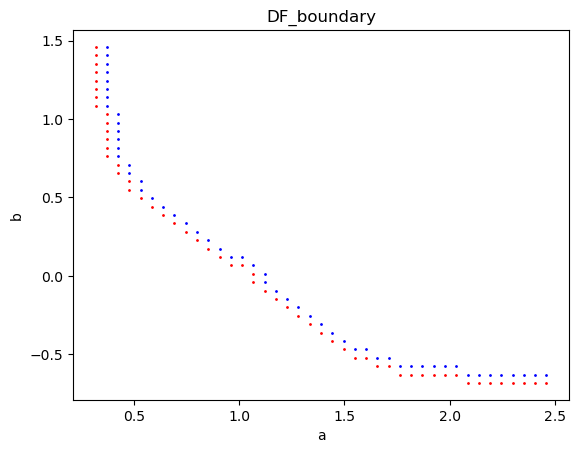

d:\Users\sinus\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


0.583**2 * RBF(length_scale=0.103)
Sum of errors for the fit  = 0.001990916276872548
The value above should hopefully be small
Iteration number 1 has began...
ETA for LogIpOverIu computation in this iteration = 17.33138342698415 seconds
ETA for LogIpOverIu computation in this iteration = 6.9067557371115385 seconds
Total time for LogIpOverIu computation in this iteration = 19.190757036209106
Iteration number 2 has began...
ETA for LogIpOverIu computation in this iteration = 76.10817551612854 seconds
ETA for LogIpOverIu computation in this iteration = 54.63163583188118 seconds
ETA for LogIpOverIu computation in this iteration = 46.147688370001944 seconds
ETA for LogIpOverIu computation in this iteration = 37.91953785896301 seconds
ETA for LogIpOverIu computation in this iteration = 29.407337991983297 seconds
ETA for LogIpOverIu computation in this iteration = 21.034553815733712 seconds
ETA for LogIpOverIu computation in this iteration = 12.621313301292625 seconds
ETA for LogIpOverIu comp

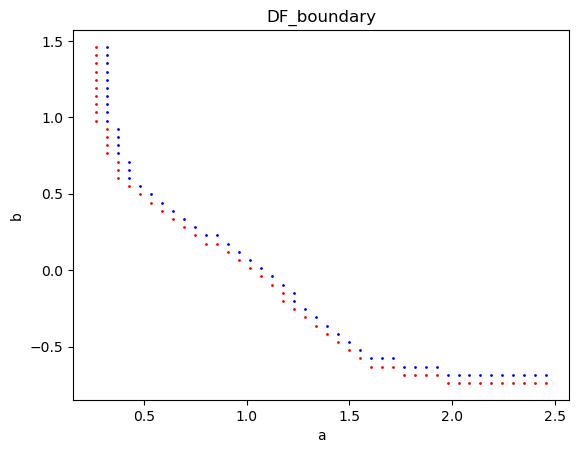

d:\Users\sinus\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


0.743**2 * RBF(length_scale=0.338)
Sum of errors for the fit  = 0.0058798919434049635
The value above should hopefully be small
Iteration number 1 has began...
ETA for LogIpOverIu computation in this iteration = 121.61971151828766 seconds
ETA for LogIpOverIu computation in this iteration = 22.963690480099448 seconds
Total time for LogIpOverIu computation in this iteration = 61.89476656913757
Iteration number 2 has began...
ETA for LogIpOverIu computation in this iteration = 114.72177028656006 seconds
ETA for LogIpOverIu computation in this iteration = 84.3931000413774 seconds
ETA for LogIpOverIu computation in this iteration = 77.82502771678723 seconds
ETA for LogIpOverIu computation in this iteration = 67.31165012995402 seconds
ETA for LogIpOverIu computation in this iteration = 51.2407029299128 seconds
ETA for LogIpOverIu computation in this iteration = 37.768084935422216 seconds
ETA for LogIpOverIu computation in this iteration = 21.72848243004567 seconds
ETA for LogIpOverIu computa

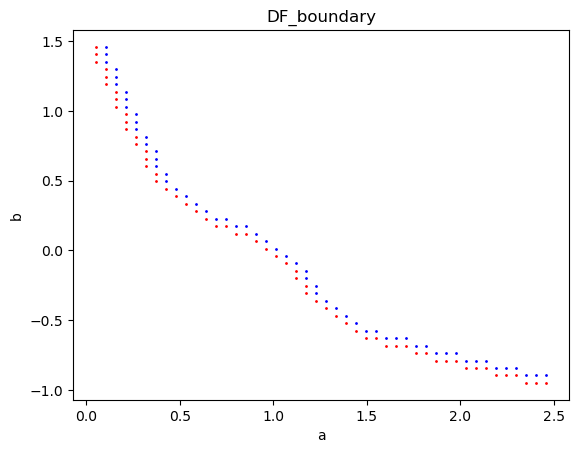

d:\Users\sinus\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


0.778**2 * RBF(length_scale=0.372)
Sum of errors for the fit  = 0.0024448423447411133
The value above should hopefully be small
Iteration number 1 has began...
ETA for LogIpOverIu computation in this iteration = 85.0944717725118 seconds
ETA for LogIpOverIu computation in this iteration = 23.12171643896948 seconds
Total time for LogIpOverIu computation in this iteration = 66.64564347267151
Iteration number 2 has began...
ETA for LogIpOverIu computation in this iteration = 181.08124351501465 seconds
ETA for LogIpOverIu computation in this iteration = 145.6634536272363 seconds
ETA for LogIpOverIu computation in this iteration = 116.73237350426223 seconds
ETA for LogIpOverIu computation in this iteration = 92.7735692161984 seconds
ETA for LogIpOverIu computation in this iteration = 69.09846339129761 seconds
ETA for LogIpOverIu computation in this iteration = 45.329336060989256 seconds
ETA for LogIpOverIu computation in this iteration = 22.505148482752276 seconds
Total time for LogIpOverIu 

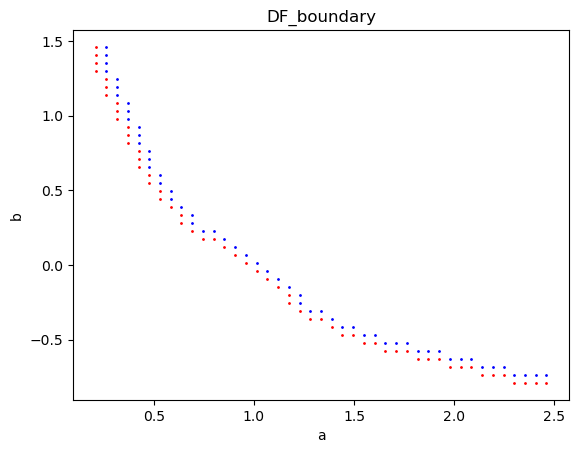

d:\Users\sinus\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


0.923**2 * RBF(length_scale=0.405)
Sum of errors for the fit  = 0.0028498964698434326
The value above should hopefully be small
Iteration number 1 has began...
ETA for LogIpOverIu computation in this iteration = 65.5873038371404 seconds
ETA for LogIpOverIu computation in this iteration = 24.988202179534525 seconds
Total time for LogIpOverIu computation in this iteration = 74.72625827789307
Iteration number 2 has began...
ETA for LogIpOverIu computation in this iteration = 162.63259188334146 seconds
ETA for LogIpOverIu computation in this iteration = 179.42622673058813 seconds
ETA for LogIpOverIu computation in this iteration = 157.26435343529047 seconds
ETA for LogIpOverIu computation in this iteration = 128.47639731089274 seconds
ETA for LogIpOverIu computation in this iteration = 100.3138257073076 seconds
ETA for LogIpOverIu computation in this iteration = 67.95627240029307 seconds
ETA for LogIpOverIu computation in this iteration = 37.92195445889825 seconds
ETA for LogIpOverIu compu

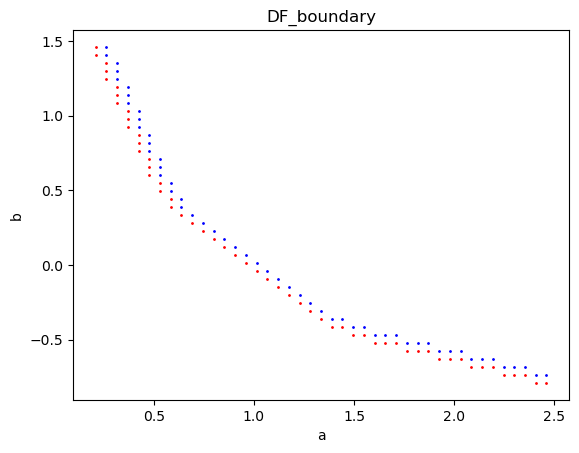

d:\Users\sinus\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


0.942**2 * RBF(length_scale=0.409)
Sum of errors for the fit  = 0.010597003329815058
The value above should hopefully be small


In [17]:
GaussianFits = []
dfs = []

for i in range(np.shape(Q_values)[0]):
    Q_value = Q_values[i]
    df = Compute_df_near_boundary(Q_value, PlotFigures= False)
    dfs.append(df)
    
    
    
    X = np.array(df[["a", "b"]])
    Y = np.array(df["LogIpOverIu"])
    
    XX =  np.random.rand(70,2)  # add  random points
    XX = (aHighestValue - aLowestValue)*XX
    XX[:,0] = XX[:,0] + aLowestValue
    XX[:,1] = XX[:,1] + bLowestValue
    YY = np.zeros(np.shape(XX)[0])
    for i in range(np.shape(YY)[0]):
        ick = Compute_Is(XX[i,0], XX[i,1], Q_value)
        YY[i] = math.log(ick[0]) - math.log(ick[1])
     
    
    
    X = np.concatenate([X,XX])
    Y = np.concatenate([Y,YY])
    
    #Y = Y.reshape(-1, 1)
    
    
    
    kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(0.03, 0.6))
    gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    gaussian_process.fit(X, Y)
    print(gaussian_process.kernel_)
    print("Sum of errors for the fit  = " + str( np.sum(np.abs(Y - gaussian_process.predict(X)))))
    print("The value above should hopefully be small")
    GaussianFits.append(gaussian_process)


In [ ]:
# special ad-hoc recomputation for i =0 cuz of low value

distance_to_points = 0.525
i = 0

Q_value = Q_values[i]
df = Compute_df_near_boundary(Q_value, PlotFigures= True)
dfs[0] = df

X = np.array(df[["a", "b"]])
Y = np.array(df["LogIpOverIu"])

XX =  np.random.rand(70,2)  # add  random points
XX = (aHighestValue - aLowestValue)*XX
XX[:,0] = XX[:,0] + aLowestValue
XX[:,1] = XX[:,1] + bLowestValue
YY = np.zeros(np.shape(XX)[0])
for i in range(np.shape(YY)[0]):
    ick = Compute_Is(XX[i,0], XX[i,1], Q_value)
    YY[i] = math.log(ick[0]) - math.log(ick[1])
    
X = np.concatenate([X,XX])
Y = np.concatenate([Y,YY])

#Y = Y.reshape(-1, 1)



kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(0.03, 0.6))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gaussian_process.fit(X, Y)
print(gaussian_process.kernel_)
print("Sum of errors for the fit  = " + str( np.sum(np.abs(Y - gaussian_process.predict(X)))))
print("The value above should hopefully be small")
GaussianFits[0] = gaussian_process

# 

In [ ]:
# recompute boundary with signs

X = np.array(df[["a", "b"]])
Y = np.array(df["Signs"])

XX =  np.random.rand(70,2)  # add  random points
XX = (aHighestValue - aLowestValue)*XX
XX[:,0] = XX[:,0] + aLowestValue
XX[:,1] = XX[:,1] + bLowestValue
YY = np.zeros(np.shape(XX)[0])
for i in range(np.shape(YY)[0]):
    ick = Compute_Is(XX[i,0], XX[i,1], Q_value)
    YY[i] = math.log(ick[0]) - math.log(ick[1])
    
X = np.concatenate([X,XX])
Y = np.concatenate([Y,YY])

#Y = Y.reshape(-1, 1)



kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(0.03, 0.6))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gaussian_process.fit(X, Y)
print(gaussian_process.kernel_)
print("Sum of errors for the fit  = " + str( np.sum(np.abs(Y - gaussian_process.predict(X)))))
print("The value above should hopefully be small")
GaussianFits[0] = gaussian_process

In [ ]:
distance_to_points = 0.225

In [45]:
bHighestValue

1.46

In [46]:
#determine boundaries using the gaussian predictor

aaaaaaas = np.linspace(start=aLowestValue +0.6, stop=aHighestValue  -0.1 , num=98) 
bbbbbbbs = np.linspace(start=bLowestValue +0.6, stop=bHighestValue-0.1, num=98) 

aas = np.array([aaaaaaas for i in range(np.shape(Q_values)[0])])
bbs = np.array([bbbbbbbs for i in range(np.shape(Q_values)[0])])

bbs_of_aas = -3* np.ones(np.shape(aas)) 
aas_of_bbs = -2* np.ones(np.shape(bbs))


for k in range(np.shape(Q_values)[0]):
    print(k)
    gaussian_process = GaussianFits[k]
    print(gaussian_process.kernel_)

    for i in range(np.shape(aas)[1]):
        a = aas[k][i]
        b = bLowestValue 
        point = np.array([a,b]).reshape(1, 2)


        Continue_while_loop = True

        while Continue_while_loop == True:

            b = b + 0.005
            point = np.array([a,b]).reshape(1, 2)
            Predicted_value = gaussian_process.predict(point)[0]
            if Predicted_value < -0.00001: 
                Continue_while_loop = False


            if b > 2.5:
                Continue_while_loop = False

        b = b - 0.005/2

        bbs_of_aas[k][i] = b



    for i in range(np.shape(bbs)[1]):
        
        
        b = bbs[k][i]
        a = aLowestValue

        point = np.array([a,b]).reshape(1, 2)


        Continue_while_loop = True

        while Continue_while_loop == True:

            a = a + 0.005
            point = np.array([a,b]).reshape(1, 2)
            Predicted_value = gaussian_process.predict(point)[0]
            if Predicted_value < -0.00001: 
                Continue_while_loop = False

            if a > 3.5:
                Continue_while_loop = False

        a = a - 0.005/2

        aas_of_bbs[k][i] = a


0
0.417**2 * RBF(length_scale=0.0915)
1
0.743**2 * RBF(length_scale=0.338)
2
0.778**2 * RBF(length_scale=0.372)
3
0.923**2 * RBF(length_scale=0.405)
4
0.942**2 * RBF(length_scale=0.409)


In [47]:
#k = 1
#b = 1
#a = -2
#gaussian_process = GaussianFits[k]

In [48]:
#            a = a + 0.105
#            point = np.array([a,b]).reshape(1, 2)
#            Predicted_value = gaussian_process.predict(point)[0]
#            print(Predicted_value)

In [49]:
import matplotlib.patches as mpatches

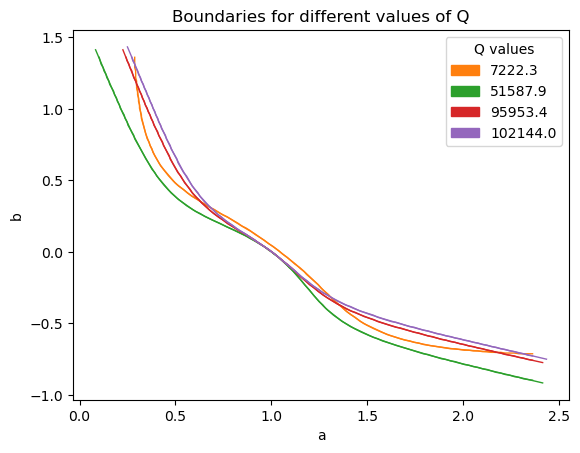

In [75]:


palette = sns.color_palette(None, np.shape(Q_values)[0])

patches = []

for k in range(1,np.shape(Q_values)[0]):

    patches.append(mpatches.Patch(color = palette[k], label ='{0:.1f}'.format(Q_values[k])))
        
    plt.plot(aas[k][bbs_of_aas[k] < bHighestValue ], bbs_of_aas[k][bbs_of_aas[k] < bHighestValue ]
                                                      , color=palette[k], linewidth=1.0)
    plt.plot( aas_of_bbs[k][aas_of_bbs[k] < aHighestValue ] , bbs[k][aas_of_bbs[k] < aHighestValue ]
                                                      , color=palette[k], linewidth=1.0)
    
    
plt.ylabel('b')
plt.xlabel('a')
plt.legend(handles=patches, loc = "upper right", title="Q values")

plt.title("Boundaries for different values of Q")
plt.savefig('Boundaries for various Q' + str(int(time.time()//1)) + '.png', bbox_inches='tight')

plt.show()    

In [51]:
fileObj = open('GaussFits for various Q' + str(int(time.time()//1)) + '.png', 'wb')
pickle.dump(GaussianFits,fileObj)
fileObj.close()

In [70]:
gaussian_process = GaussianFits[0]

In [71]:
        aaaas = np.linspace(start=aLowestValue, stop= aHighestValue, num=111) 
        bbbbs = np.linspace(start=bLowestValue, stop= bHighestValue, num=111)


        # get cartesian product of aas and bbs
        DF = pd.MultiIndex.from_product([aaaas, bbbbs], names = ["a", "b"])
        DF = pd.DataFrame(index = DF).reset_index()
        zeros = np.zeros(( DF.shape[0],1))
        DF["LogPrediction"] = zeros 
        for i in range(len(DF)):
            a = DF.loc[i,"a"]
            b = DF.loc[i,"b"]
            point = np.array([a,b]).reshape(1, 2)
            
            DF.loc[i, "LogPrediction"] =  gaussian_process.predict(point)[0]
            
            

In [72]:
Color_var = np.array(DF["LogPrediction"]) 

MinValue = np.min(Color_var)
MaxValue = np.max(Color_var)

scaled_Color_var = np.zeros(np.shape(Color_var))

for i in range(np.shape(Color_var)[0]): 
    # colors are scaled piece-wisely linear in such a way that scaled_Color_var[i] = 0 if 
    # Color_var[i] = 0. In this way if df["LogIpOverIu"][i] = 0, the color is gonna be in the middle between red and blue.
    z = Color_var[i]
 
    if z < 0:
        scaled_Color_var[i] = 0.5 - 0.5*z/MinValue  
    else:
        scaled_Color_var[i] = 0.5 + 0.5*z/MaxValue 
        

colors = plt.cm.coolwarm(scaled_Color_var)

def inverse_color_transform(s):
    if s >= 0.5:
        return_value = MaxValue*(2*s-1)
    else:
        return_value = MinValue*(1-2*s)
    return return_value

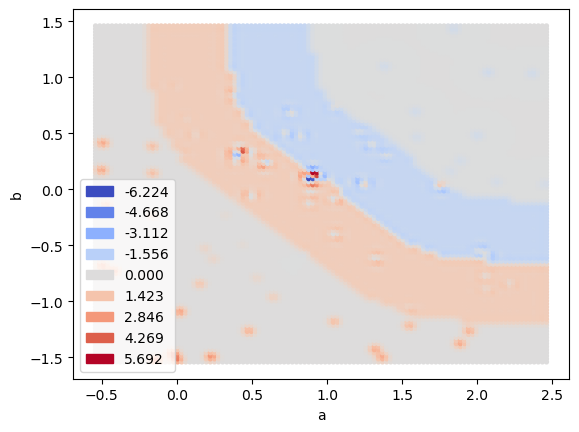

In [73]:
plt.scatter(DF["a"], DF["b"],  color=colors, s=7.8)
#plt.plot(aas, bbs_of_aas, color='purple', linewidth=1.5)
#plt.plot( aas_of_bbs, bbs, color='purple', linewidth=1.5)
plt.ylabel('b')
plt.xlabel('a')



patches = []

Numbers_from_0_to_1 = np.linspace(start = 0, stop = 1, num = 9)

for i in range(np.shape(Numbers_from_0_to_1)[0]):
    patches.append(mpatches.Patch(color=plt.cm.coolwarm(Numbers_from_0_to_1[i]),
                                  label= '{0:.3f}'.format(inverse_color_transform(Numbers_from_0_to_1[i])) ) )


plt.legend(handles=patches, loc = "lower left")
#plt.savefig('Poland_Boundary_viridis.png', bbox_inches='tight')
plt.show()

In [64]:
df = dfs[0]

In [68]:
df

,a,b,LogIpOverIu,Signs
0,1.174286,0.174286,-0.099050,-1
1,1.870714,-0.736429,0.204380,1
2,0.424286,1.352857,-0.093410,-1
3,1.977857,-0.897143,0.687444,1
4,2.192143,-0.093571,-0.326515,-1
...,...,...,...,...
1281,0.906429,0.549286,-0.145936,-1
1282,-0.004286,1.245714,1.202903,1
1283,1.067143,0.174286,-0.055603,-1
1284,2.460000,-1.165000,1.981692,1


In [65]:
Color_var = np.array(df["LogIpOverIu"]) 

MinValue = np.min(Color_var)
MaxValue = np.max(Color_var)

scaled_Color_var = np.zeros(np.shape(Color_var))

for i in range(np.shape(Color_var)[0]): 
    # colors are scaled piece-wisely linear in such a way that scaled_Color_var[i] = 0 if 
    # Color_var[i] = 0. In this way if df["LogIpOverIu"][i] = 0, the color is gonna be in the middle between red and blue.
    z = Color_var[i]
 
    if z < 0:
        scaled_Color_var[i] = 0.5 - 0.5*z/MinValue  
    else:
        scaled_Color_var[i] = 0.5 + 0.5*z/MaxValue 
        

colors = plt.cm.coolwarm(scaled_Color_var)

def inverse_color_transform(s):
    if s >= 0.5:
        return_value = MaxValue*(2*s-1)
    else:
        return_value = MinValue*(1-2*s)
    return return_value

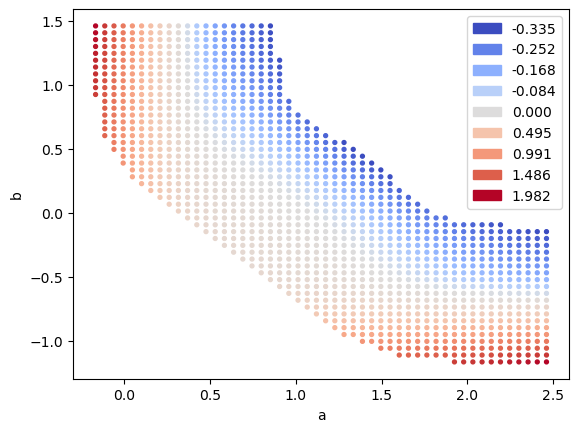

In [67]:
plt.scatter(df["a"], df["b"],  color=colors, s=7.8)
#plt.plot(aas, bbs_of_aas, color='purple', linewidth=1.5)
#plt.plot( aas_of_bbs, bbs, color='purple', linewidth=1.5)
plt.ylabel('b')
plt.xlabel('a')



patches = []

Numbers_from_0_to_1 = np.linspace(start = 0, stop = 1, num = 9)

for i in range(np.shape(Numbers_from_0_to_1)[0]):
    patches.append(mpatches.Patch(color=plt.cm.coolwarm(Numbers_from_0_to_1[i]),
                                  label= '{0:.3f}'.format(inverse_color_transform(Numbers_from_0_to_1[i])) ) )


plt.legend(handles=patches, loc = "upper right")
#plt.savefig('Poland_Boundary_viridis.png', bbox_inches='tight')
plt.show()

d:\Users\sinus\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.03. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.998**2 * RBF(length_scale=0.03)
Sum of errors for the fit  = 1.8796018511069157e-07
The value above should hopefully be small
